In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')

import GaussianODEs as ode

In [21]:
mu0 = 0
C0 = 1

mu = 0 
C = 100

## Log-concavity constant

In [22]:
## exact WFR evolution 
discr = 1000
gamma = 0.01
mean_eq_wfrinf, var_eq_wfrinf, _ = ode.wfr_infinite_time(mu0, mu, C0, C, discr, gamma)

Derivation of constants for Theorem 4.1:

Recall $V_0(x) = x^2/2$ and $V_\pi(x) = x^2/(2C_\pi) = \alpha_\pi x^2/2 $. Then, 
$$V_0(x) - \frac{(1+\delta)}{2}V_\pi(x) = \frac{x^2}{2}- \frac{\alpha_\pi(1+\delta)}{2}\frac{x^2}{2}$$
is strongly convex with parameter $\alpha_d = \frac{1}{2}-\alpha_\pi\frac{(1+\delta)}{4}>0$ for $\delta<2/\alpha_\pi-1$.

For $\mathcal{H}$ we compute
$$\mathcal{H}(x) = -\frac{\alpha_\pi}{2}+\frac{1}{4}\alpha_\pi^2x^2+\alpha_\pi\frac{x^2}{2}$$
which is strongly convex with parameter $\alpha_h = \alpha_\pi+\frac{\alpha_\pi^2}{4}$.

In [23]:
## evolution from Theorem 4.1
alphapi = 1/C
Lpi = 1/C

delta = 2/alphapi-1-0.1
alphad = 0.5-alphapi*(1+delta)/4
c0 = alphad+delta/2*alphapi

alphah = alphapi+alphapi**2/4
b = np.sqrt(0.5*(alphah-Lpi))


cinf1 = 0.5*(-1+np.sqrt(1+4*(alphapi/2-b**2)))
cinf2 = 0.5*(-1-np.sqrt(1+4*(alphapi/2-b**2)))
l0 = (c0-cinf1)/(c0-cinf2)

In [24]:
alpha_eq_theo = np.zeros(discr+1)
alpha_eq_theo[0] = 1/C0
for i in range(discr):
    t = gamma*(i+1)
    alpha_eq_theo[i+1] = alphapi/2 + (cinf1-cinf2*l0*np.exp(-t*(cinf1-cinf2)))/(1-l0*np.exp(-t*(cinf1-cinf2)))

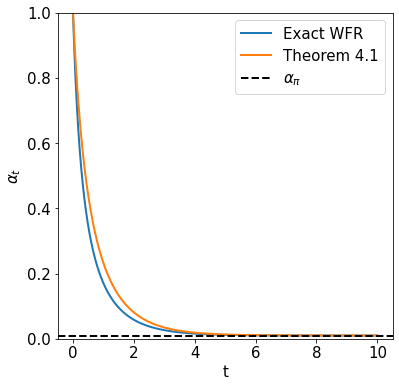

In [37]:
plt.figure(figsize = (6, 6))
plt.plot(gamma*np.arange(discr+1), 1/var_eq_wfrinf, label = 'Exact WFR', lw = 2)
plt.plot(gamma*np.arange(discr+1), alpha_eq_theo, label = 'Theorem 4.1', lw = 2)
plt.axhline(y=alphapi, color='black', linestyle='--', label = r'$\alpha_\pi$', lw = 2)
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel(r'$\alpha_t$', fontsize = 15)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
plt.ylim(0, 1);
# plt.savefig('alphat_1.pdf', bbox_inches="tight")

## Symmetrised KL decay

In [39]:
mu0 = 0
C0 = 1

mu = 20 
C = 100

## exact WFR evolution 
discr = 1000
gamma = 0.01
mean_eq_wfrinf, var_eq_wfrinf, _ = ode.wfr_infinite_time(mu0, mu, C0, C, discr, gamma)

In [40]:
## exact WFR decay
j_exact = np.zeros(discr+1)
for i in range(discr+1):
    j_exact[i] = ode.KL(mean_eq_wfrinf[i], var_eq_wfrinf[i], mu, C) + ode.KL(mu, C, mean_eq_wfrinf[i], var_eq_wfrinf[i])

In [41]:
## Proposition 5.1
j_theo = np.zeros(discr+1)
j_theo[0] = ode.KL(mu0, C0, mu, C) + ode.KL(mu, C, mu0, C0)
for i in range(1, discr+1):
    t = gamma*i
    j_theo[i] = j_theo[0]*np.exp(-t*(1+alphapi))

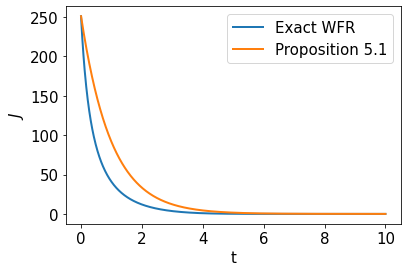

In [43]:
plt.plot(gamma*np.arange(discr+1), j_exact, label = 'Exact WFR', lw = 2)
plt.plot(gamma*np.arange(discr+1), j_theo, label = 'Proposition 5.1', lw = 2)
plt.legend(fontsize = 15)
plt.xlabel('t', fontsize = 15)
plt.ylabel(r'$J$', fontsize = 15)
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);
# plt.savefig('j_rate.pdf', bbox_inches="tight")